In [1]:
import time
import copy as cp

import numpy as np
from numba import jit, njit
PI = np.pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
plt.rcParams['image.cmap']='cool'  ## set a global cmap: 'cool' ,   'twilight_shifted', 'hsv', 'jet'
cmap = 'cool'
alpha = 0.9


In [2]:
def plot_2D(f, x_label = '$x$', y_label = '$y$', title='$f(x,y)$'):
    
    fig, ax = plt.subplots(figsize = (6, 10))
    ax.imshow(f, cmap='cool', origin='lower')
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_title(title, fontsize = 20) ;
    plt.show()


def plot_3D(x,y,z, x_label = '$x$', y_label ='$y$', z_label = '$z$', title='$f(x,y)$', elev=15., azim=0):  
    
    fig = plt.figure( figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap = cmap, alpha = alpha)
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_zlabel(z_label, fontsize=15);
    ax.set_title(title, fontsize = 20);
    ax.view_init(elev=elev, azim=azim)
    plt.show()

# Problem to solve: Poisson equation

$$ \frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{\partial y^2} = f(x,y) $$

where 
$$f(x,y) = \cos (3x + 4y) - \cos(5x - 2y)$$

with periodic boundary conditions:
* $\phi(x,0) = \phi(x, 2\pi)$
* $\phi(0,y) = \phi(2\pi, y)$



In [3]:
def f(x, y):
    return np.cos(3*x + 4*y) - np.cos(5*x-2*y)

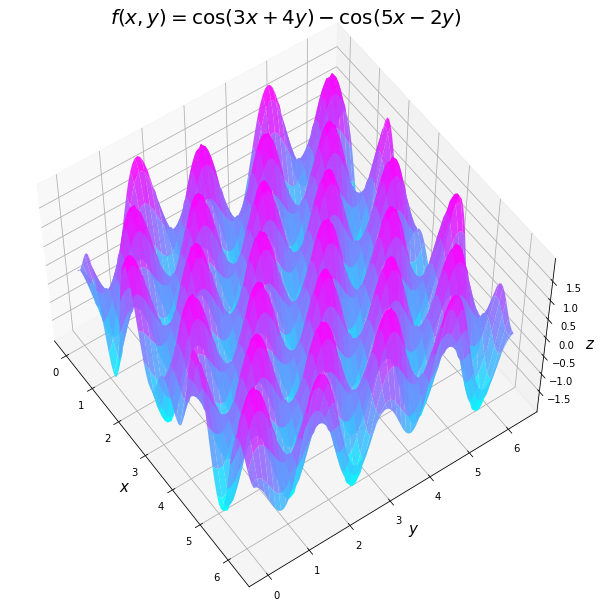

In [4]:
n = 100
xx = np.linspace(0, 2*PI, n)
yy = np.linspace(0, 2*PI, n)
x,y = np.meshgrid(xx,yy)

source = f(x,y) 

plot_3D(x, y, source, title = '$f(x,y) = \cos(3x + 4y) - \cos(5x-2y)$', elev=55., azim=-35)

# 1. Analitical solution

$$\phi(x,y) = -\frac{1}{25} \cos(3x+4y) + \frac{1}{29} \cos(5x-2y)$$

In [5]:
def analitical_solution(x,y):
    return -np.cos(3*x + 4*y)/25 + np.cos(5*x-2*y)/29

In [6]:
n = 100
xx = np.linspace(0, PI, n)
yy = np.linspace(0, PI, n)
x,y= np.meshgrid(xx,yy)

sol = analitical_solution(x,y)

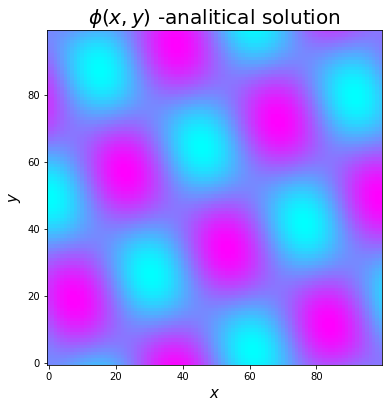

In [7]:
plot_2D(sol, title = '$\phi(x,y)$ -analitical solution')

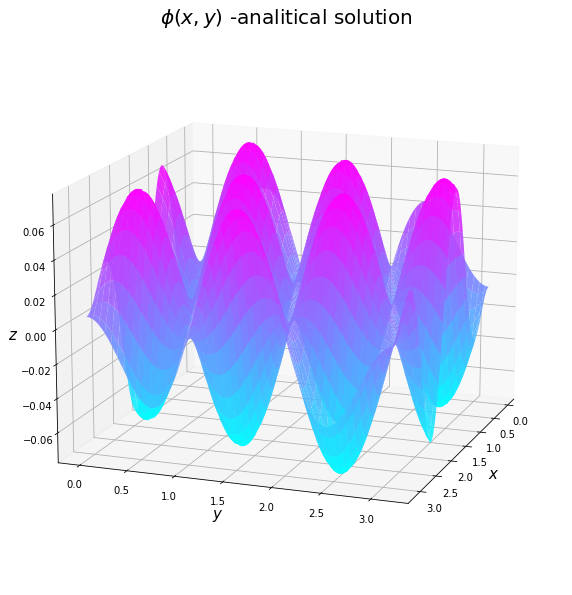

In [8]:
plot_3D(x, y, sol, title = '$\phi(x,y)$ -analitical solution', elev=15., azim=20)

# 2. Discrete Fourier Transform

0. Discrete Fourier Transform:
$$ f_{pq} = \frac{1}{n^2} \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1} e^{2\pi i k p/n} e^{2\pi i lq/n} \cdot \tilde{f}_{kl}$$

Inverse Discrete Fourier Transform:

$$ \tilde{f}_{kl} = \sum _{p=0}^ {n-1} \sum_{q=0}^{n-1}  e^{-2\pi i k p/n} e^{-2\pi i lq/n} \cdot f_{pq}  $$


1. discretization:
* $x_p = \frac{2\pi p}{n}, p=0,1,2,..,n-1$
* $y_q = \frac{2\pi q}{m}, q=0,1,2,..,m-1$
* $\phi(x_p, y_q) = \phi_{p,q}$
* $f(x_p, y_q) = f_{p,q}$


2. central-difference approximation to the second-derivative:

$$ \frac{\phi_{p+1, q} - 2\phi_{p,q} + \phi_{p-1, q}}{h^2} + 
    \frac{\phi_{p, q+1} - 2\phi_{p,q} + \phi_{p, q-1}}{h^2} = f_{p,q}$$
    
$$ \phi_{p+1, q} + \phi_{p-1, q} + \phi_{p, q+1} + \phi_{p, q-1} - 4\phi_{p,q} = h^2 \cdot f_{p,q}$$


3. we want to find $\phi _{p,q}$. We use DFT. In fourier space we dont have spatial derivatives. Let n = m for simplicity. 

$$\phi_{pq} = \frac{1}{n^2} \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1} e^{2\pi i k p/n} \cdot e^{2\pi i lq/n} \cdot\tilde{\phi}_{kl}$$



$$ f_{pq} = \frac{1}{n^2} \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1} e^{2\pi i k p/n} e^{2\pi i lq/n} \cdot \tilde{f}_{kl}$$

$p,q = 1,2,..., n-1$




4. We insert $\phi_{kl}$ and $f_{kl}$ into the formula for central-difference approximation to the second-derivative:

$$ \phi_{p+1, q} + \phi_{p-1, q} + \phi_{p, q+1} + \phi_{p, q-1} - 4\phi_{p,q} - h^2 \cdot f_{p,q} = 0$$


$$ 
\frac{1}{n^2} \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1} e^{2\pi i k p/n} \cdot e^{2\pi i lq/n} 
\left[
\tilde{\phi_{kl}} \left( e^{2\pi i k/n} +  e^{-2\pi i k/n} +  e^{2\pi i l/n} + e^{2\pi i l/n} -4\right)
-h^2\cdot \tilde{f}_{kl}
\right] = 0
$$


We multiplicate both sides with $e^ {-2\pi i k' p/n}e^ {-2\pi i l' q/n}$ and sum over $p$ and $q$. From the orthonormality condition we get deltas. 


$$ 
\frac{1}{n^2} \sum _{p=0}^ {n-1} \sum_{q=0}^{n-1}  \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1}
e^{-2\pi i k' p/n} \cdot e^{-2\pi i l'q/n} 
e^{2\pi i k p/n} \cdot e^{2\pi i lq/n} 
\left[
\tilde{\phi}_{kl} \left( e^{2\pi i k/n} +  e^{-2\pi i k/n} +  e^{2\pi i l/n} + e^{2\pi i l/n} -4\right)
-h^2\cdot \tilde{f_{kl}}
\right] = 0
$$

$$ 
\frac{1}{n^2} \sum _{p=0}^ {n-1} \sum_{q=0}^{n-1}  \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1}
e^{2\pi i ( k-k') p/n} \cdot e^{2\pi i (l-l')q/n} 
\left[
\tilde{\phi_{kl}} \left( e^{2\pi i k/n} +  e^{-2\pi i k/n} +  e^{2\pi i l/n} + e^{2\pi i l/n} -4\right)
-h^2\cdot \tilde{f_{kl}}
\right] = 0
$$


$$ 
\frac{1}{n^2} \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1} \delta_{k, k'} \delta_{l, l'}
\left[
\tilde{\phi}_{kl} \left( e^{2\pi i k/n} +  e^{-2\pi i k/n} +  e^{2\pi i l/n} + e^{2\pi i l/n} -4\right)
-h^2\cdot \tilde{f}_{kl}
\right] = 0
$$


$$ 
\tilde{\phi}_{k'l'}\left[ 2\cos \left( 2\pi i \frac{k'}{n} \right) + 2\cos \left( 2\pi i \frac{l'}{n}\right)-4
\right]
-h^2\cdot \tilde{f}_{k'l'}
 = 0
$$

5. Finally, we get a nice formula for $\tilde{\phi}_{k'l'}$

$$ 
\tilde{\phi}_{k'l'} = \frac{1}{2} \cdot 
\frac{h^2\cdot \tilde{f}_{k'l'}}{\cos \left( 2\pi \frac{k'}{n} \right) + \cos \left( 2\pi \frac{l'}{n}\right)-2}
$$

6. Using the inverse DFT we get $\phi _{kl}$

$$\phi_{pq} = \frac{1}{n^2} \sum _{k=0}^ {n-1} \sum_{l=0}^{n-1} e^{2\pi i k p/n} \cdot e^{2\pi i lq/n} \cdot\tilde{\phi}_{kl}$$


In [9]:
def DFT_1(f,n):
    f = f.astype(complex)
    f_tilde = np.zeros_like(f).astype(complex)
    for k in range(n):
        for l in range(n):
            for p in range(n):
                for q in range(n):
                    f_tilde[k][l] += f[p][q] * np.exp(-2*PI*1j*k*p/n) * np.exp(-2*PI*1j*l*q/n)            
    return f_tilde 



def IDFT_1(f_tilde,n):
    f_tilde = f_tilde.astype(complex)
    f = np.zeros_like(f_tilde).astype(complex)
    for p in range(n):
        for q in range(n):
            for k in range(n):
                for l in range(n):
                    f[p][q] += f_tilde[k][l] * np.exp(2*PI*1j*k*p/n) * np.exp(2*PI*1j*l*q/n)                   
    return f.real/(n*n)  


def get_coeffs(f_tilde, n, h):
    f_tilde = f_tilde.astype(complex)
    g_tilde = np.zeros_like(f_tilde).astype(complex)      
    for k in range(n):
        for l in range(n):           
            g_tilde[k][l] = 0.5 * h * h * f_tilde[k][l]/ (np.cos( 2*PI*k/n) + np.cos( 2*PI*l/n)-2)                
    g_tilde[0][0] = 0  ## from analitical calculations
    return g_tilde 

In [10]:
n = 100
xp_ = np.linspace(0,n-1, n)* 2* PI /n
yq_ = np.linspace(0,n-1, n)* 2* PI /n
xp,yq = np.meshgrid(xp_,yq_)

h = xp_[1] - xp_[0]

f_pq = f(xp,yq) 
f_tilde_kl = DFT_1(f_pq, n)

g_tilde = get_coeffs(f_tilde_kl, n, h)
g = IDFT_1(g_tilde, n)

<ipython-input-9-3f7a7f2a7b90>:29: RuntimeWarning: divide by zero encountered in cdouble_scalars
  g_tilde[k][l] = 0.5 * h * h * f_tilde[k][l]/ (np.cos( 2*PI*k/n) + np.cos( 2*PI*l/n)-2)
<ipython-input-9-3f7a7f2a7b90>:29: RuntimeWarning: invalid value encountered in cdouble_scalars
  g_tilde[k][l] = 0.5 * h * h * f_tilde[k][l]/ (np.cos( 2*PI*k/n) + np.cos( 2*PI*l/n)-2)


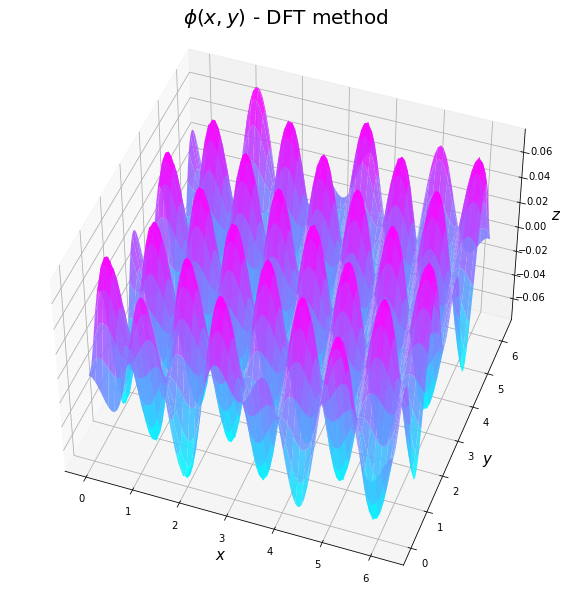

In [11]:
plot_3D(xp, yq, g, title = '$\phi(x,y)$ - DFT method', elev=45., azim=-70)

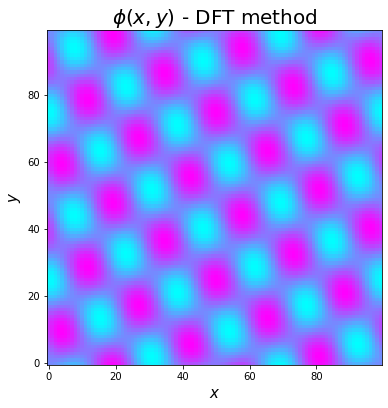

In [12]:
plot_2D(g, title = '$\phi(x,y)$ - DFT method')

# 3. Matrix form: Ax = b


$$ \frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{\partial y^2} = f(x,y) $$

where 
$$f(x,y) = \cos (3x + 4y) - \cos(5x - 2y)$$

with periodic boundary conditions:
* $\phi(x,0) = \phi(x, 2\pi)$
* $\phi(0,y) = \phi(2\pi, y)$


The lowest order $\mathcal{O}(h^2)$ disretization has the form:

$$ \frac{\phi_{p+1, q} - 2\phi_{p,q} + \phi_{p-1, q}}{h^2} + 
    \frac{\phi_{p, q+1} - 2\phi_{p,q} + \phi_{p, q-1}}{h^2} = f_{p,q}$$
    
$$ \frac{\phi_{p+1, q} + \phi_{p-1, q} + \phi_{p, q+1} + \phi_{p, q-1}  - 4\phi_{p,q}}{h^2} = f_{p,q}$$

We want to write the above equation in a matrix form: $D \vec{\phi} = f$ where
matrix $D$ correspons to coefficients, vector $\vec{\phi}$ corresponds to discretized coordinates $[\phi_{pq}]$ and $f_{pq}$ are know values of f evaluated at discrete points $f_{pq} = f(x_p, y_q)$

We have $n \cdot n = n^2$ unknow $\phi _{pq}$. First of all, we need to vectorize $\phi_{pq}$ and $f_{pq}$. In order to do that, we introduce a multiindex:

$$0\leq I_{i,j} = iN+j<N^2$$

$$\phi_{I-N}+\phi_{I+N}+\phi_{I-1}+\phi_{I+1}-4\phi_{I}= A_{IJ}x_J = h^2 \cdot f_{I}$$

$$A_{IJ} = \delta_{I-N, J}+\delta_{I+N, J}+\delta_{I-1, J}+\delta_{I+1, J}-4\delta_{I,J}$$

Boundary conditions:
$$\phi_{[0:N]}=\phi_{bottom}\qquad \phi_{[0:N(N-1):N]}=\phi_{left}$$

$$\phi_{[N(N-1):N^2]}=\phi_{top}\qquad \phi_{[(N-1):N^2:N]}=\phi_{right}$$

In [13]:
n = 100
xx = np.linspace(0, 2*PI, n)
yy = np.linspace(0, 2*PI, n)

dx = xx[1] - xx[0]
dy = yy[1] - yy[0]

x,y= np.meshgrid(xx,yy)

f_matrix = f(x,y)
f_vector = f_matrix.flatten()

N = len(f_vector)

D = np.diagflat( np.ones(N) * (-4))

for i in range(1,N-1):
    D[i][i] = -4
    D[i][i+1] = 1
    D[i][i-1] = 1
    D[i][(i+n)%N] = 1
    D[i][(i-n)%N] = 1

## Periodic boundary conditions:
D[N-1][N-2] = 1
D[N-1][n-1] = 1
D[N-1][N-n-1] = 1

D[0][1]= 1
D[0][N-n]=1
D[0][n]=1

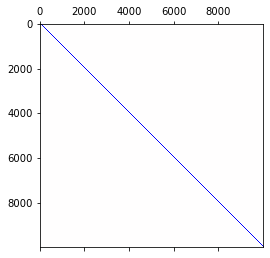

In [14]:
plt.matshow(D, cmap='bwr', vmin=-4, vmax=4)

In [15]:
import scipy.sparse as sp  # provides sparse matrices
import scipy.sparse.linalg as sl

In [16]:
Φ1_vector = np.linalg.solve(D, f_vector) 

In [17]:
Φ2_vector = sl.spsolve(D, f_vector)

/home/neofelia/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [18]:
Φ1_matrix = cp.copy(Φ1_vector).reshape((n, n))
Φ2_matrix = cp.copy(Φ2_vector).reshape((n, n))

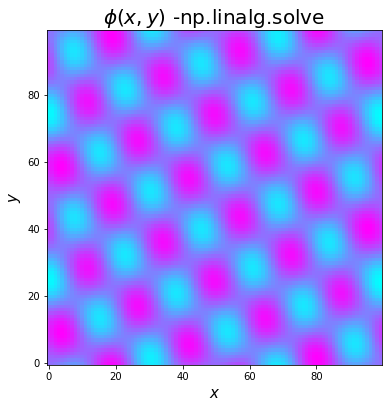

In [19]:
plot_2D(Φ1_matrix, title = '$\phi(x,y)$ -np.linalg.solve')

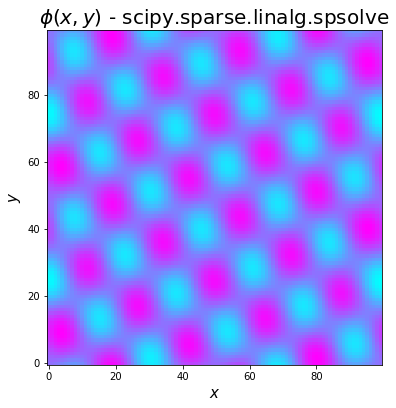

In [20]:
plot_2D(Φ2_matrix, title = '$\phi(x,y)$ - scipy.sparse.linalg.spsolve')

#### LU decomposition:

We rewrite matrix $A$ as $A=LU$, where where $L$ and $U$ are lower and upper triangular matrices.
Then:

$$Ax=b\;\Rightarrow\;LUx=b\;\Rightarrow\;\begin{cases}
Ly&=b\\
Ux&=y
\end{cases}$$

Forward substitution:

$$\begin{bmatrix}l_{11}&0&0\\l_{21}&l_{22}&0\\l_{31}&l_{32}&l_{33}\end{bmatrix}
\begin{bmatrix}y_1\\y_2\\y_3\end{bmatrix}=
\begin{bmatrix}b_1\\b_2\\b_3\end{bmatrix} $$


$$y_1=\frac{b_1}{l_{11}},\qquad y_2=\frac{b_2-l_{21}y_1}{l_{22}},\qquad y_3=\frac{b_3-l_{31}y_2-l_{32}y_2}{l_{33}}$$


Backward substitution:

$$\begin{bmatrix}u_{11}&u_{12}&u_{13}\\0&u_{22}&u_{23}\\0&0&u_{33}\end{bmatrix}
\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}=
\begin{bmatrix}y_1\\y_2\\y_3\end{bmatrix}$$

$$x_3=\frac{y_3}{u_{33}},\qquad x_2=\frac{y_2-u_{23}x_3}{u_{22}},\qquad x_1=\frac{y_1-u_{12}x_2-u_{13}x_3}{u_{11}}$$

#### dollittle method:

1. For given matrix $ A = (n \times n)$ we prepare two matrices $L, U= (n \times n)$
2. We set the diagonal of $L$ to 1
3. We find $U_{ij}$ and $L_{ij}$ from:
$$ u_{ij}=a_{ij}-\sum _{k=1}^{i-1}l_{ik}u_{kj}\qquad i\leq j\leq n $$
$$ l_{ji}={\frac {1}{u_{ii}}}\left(a_{ji}-\sum _{k=1}^{i-1}l_{jk}u_{ki}\right) \qquad i< j\leq n $$

4. (Theoretically) A = LU


In [21]:
def LU_Doolittle(A):

    A = A.astype(np.float64)
    n= A.shape[0]
    L = np.zeros_like(A).astype(np.float64)
    U = np.zeros_like(A).astype(np.float64)
    np.fill_diagonal(L,1)
    
    print("A.shape = {:}\t rank(A) = {:}\t\t det(A) {:}".format(A.shape, np.linalg.matrix_rank(A),  np.linalg.det(A)))
    
    for i in range(n):
        for j in range(i, n):
            U[i,j] = A[i,j] - np.sum(L[i,:i]*U[:i, j])
            #U[i][j] = A[i][j] - sum( L[i][k]*U[k][j] for k in range(i))
              
        for j in range(i+1,n):
            #print("i = ", i,"j = ", j, "\t", U[0][0], U[1][1], U[2][2], U[3][3], 1.0 /U[i][i], "\n")

            ##both methods give the same results:
            #L[j][i] = (A[j][i]- sum( L[j][k]*U[k][i] for k in range(i))) / U[i][i]
            L[j,i] = 1.0/U[i][i] * (A[j,i] - np.sum(L[j,:i]*U[:i, i]))
    
    return L, U

In [22]:
A = np.array([[1,2,3,4], [2,1,3,1], [4,1,5,2], [19,17,13,11]])
L, U = LU_Doolittle(A)

B = np.matmul(L,U) 
print("\n",A)
print("\n", B.round(5))
(A-B).round(5)

A.shape = (4, 4)	 rank(A) = 4		 det(A) -160.9999999999999

 [[ 1  2  3  4]
 [ 2  1  3  1]
 [ 4  1  5  2]
 [19 17 13 11]]

 [[ 1.  2.  3.  4.]
 [ 2.  1.  3.  1.]
 [ 4.  1.  5.  2.]
 [19. 17. 13.  8.]]


array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0., -0., -0.,  0.],
       [ 0.,  0.,  0.,  3.]])

In [23]:
A = np.array([[1,0,3,4], [0,1,0,1], [0,1,5,0], [0,17,13,0]])

L, U = LU_Doolittle(A)


B = np.matmul(L,U) 
print("\n",A)
print("\n", B.round(5))
(A-B).round(5)

A.shape = (4, 4)	 rank(A) = 4		 det(A) -72.0

 [[ 1  0  3  4]
 [ 0  1  0  1]
 [ 0  1  5  0]
 [ 0 17 13  0]]

 [[ 1.  0.  3.  4.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  5.  0.]
 [ 0. 17. 13. -0.]]


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [24]:
A = np.random.randint(0, 20, (10,10)) 
L, U = LU_Doolittle(A)

B = np.matmul(L,U) 
print("\n",A)
print("\n", B.round(5))
(A-B).round(5)

A.shape = (10, 10)	 rank(A) = 10		 det(A) 55305469944.00014

 [[18  0  6  0 11  1  9 11  3  9]
 [ 6  6  2  0  9  2 14 17 17 15]
 [ 0  2 15 17  7 10 12  5 15  9]
 [ 4 17  9 18 11 11 18  2 17 13]
 [ 3  1 14 16  7 11 11 13 18 18]
 [ 5  2 12  5 11  2 13 14 13 10]
 [ 1 13 12  9  4 16 11  1  1  1]
 [19  2  5  7 12 11 12 19  8  1]
 [ 0 15  2 14  2 19  8  4  2 16]
 [ 0 16 15  3 16 12 14 14 15  4]]

 [[18.  0.  6.  0. 11.  1.  9. 11.  3.  9.]
 [ 6.  6.  2.  0.  9.  2. 14. 17. 17. 15.]
 [ 0.  2. 15. 17.  7. 10. 12.  5. 15.  9.]
 [ 4. 17.  9. 18. 11. 11. 18.  2. 17. 13.]
 [ 3.  1. 14. 16.  7. 11. 11. 13. 18. 18.]
 [ 5.  2. 12.  5. 11.  2. 13. 14. 13. 10.]
 [ 1. 13. 12.  9.  4. 16. 11.  1.  1.  1.]
 [19.  2.  5.  7. 12. 11. 12. 19.  8.  1.]
 [ 0. 15.  2. 14.  2. 19.  8.  4.  2. 16.]
 [ 0. 16. 15.  3. 16. 12. 14. 14. 15.  4.]]


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.]])

In [25]:
A = np.random.randint(0, 20, (15,15)) 
L, U = LU_Doolittle(A)

B = np.matmul(L,U) 
print("\n",A)
print("\n", B.round(5))
(A-B).round(5)

A.shape = (15, 15)	 rank(A) = 15		 det(A) -1.0670024322779283e+17

 [[ 5  8 19 13 14 10 12 16 19 19 12 10 14 18  6]
 [11 19 11 16  9  6 16 18  6 14 14  8 17 12  1]
 [11  7 13 14 14 17  7  4 17  5  5  0 16  5  4]
 [11  6  5  7  5 12 10  2  0  2 13  5 10 12 11]
 [ 6 15 15  7  0  8 15  0 11 15 17 19  2 11 17]
 [ 7  7 15  3  1 13 11  8 19  8  9 11  7 13 19]
 [17 16  5  2  0 19  3  4  7  6 18  8  9 11  9]
 [ 1  1 15 12 10 16 13 18  5 17  1  4 14 17  3]
 [ 1  7 18  1  1 13 14  8 18  4  9  3 12 14  2]
 [17 10  7  6  9  3  1  4  6  7  4 18  6  7 15]
 [ 5  2 14 17 12 13 19 15  6 12  4  6 11  8 15]
 [16 10 19  1  1  7 11 13 11  6  2 12 15  2  3]
 [ 1  9 15 11 19 15  5 12  1  2  6 19 17  1  8]
 [ 5 11 18 11  0 16 16  1 19  9 18  6  7  6 13]
 [19 13 11  1  4  5  7  6  1 16 15 11  5  8 13]]

 [[ 5.  8. 19. 13. 14. 10. 12. 16. 19. 19. 12. 10. 14. 18.  6.]
 [11. 19. 11. 16.  9.  6. 16. 18.  6. 14. 14.  8. 17. 12.  1.]
 [11.  7. 13. 14. 14. 17.  7.  4. 17.  5.  5.  0. 16.  5.  4.]
 [11.  6.  5.  7.  5

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,
        -0.,  0.],
       [-0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -0., -0.],
       [ 0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        -0.,  0.],
       [ 0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
         0., -0.],
       [ 0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,
       